In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [2]:
def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0][0])
    print(frames[0][1])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i][0])
        print(frames[i][1])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

In [3]:
env = gym.make("CartPole-v0")

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical

class QualityNet(nn.Module):
    '''Takes a state and returns probabilities for each action.'''
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(4, 16)
        self.layer_2 = nn.Linear(16, 16)
        self.layer_3 = nn.Linear(16, 2)
    def forward(self, state):
        x = torch.Tensor(state)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x
Q = QualityNet()

epsilon = 1
def policy(state):
    global epsilon
    action_probabilities = F.softmax(Q(state))
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.choice(env.action_space.n)
        epsilon *= 0.999
    else:
        #action = Categorical(action_probabilities).sample().item()
        max_prob, action = torch.max(action_probabilities, dim=0)
        action = action.numpy()
        #print(state, Q(state))
    return action

In [18]:
from torch import optim

class MemoryBank():
    def __init__(self):
        self.memories = []
        self.n_replay = 50
        self.gamma = 0.95
        self.learning_rate = 1
        self.optimizer = optim.Adam(Q.parameters(), lr=self.learning_rate)
        self.loss_function = nn.MSELoss()
    def remember(self, memory):
        self.memories.append(memory)
    def recall(self):
        return self.memories[np.random.randint(len(self.memories))]
    def recall_and_learn(self):
        if len(self.memories) < self.n_replay*10:
            return
        for _ in range(self.n_replay):
            state, action, reward, new_state, game_over = self.recall()
            old_quality = Q(state)[action]
            if (game_over):
                new_quality = torch.Tensor([reward])
            else:
                new_quality = reward + self.gamma*target_Q(new_state)[torch.max(Q(new_state), dim=0)[1]]
            loss = self.loss_function(old_quality, new_quality)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.learning_rate *= 0.999
            if (self.learning_rate < 0.0001):
                self.learning_rate = 0.0001
memory = MemoryBank()

In [19]:
import copy

training_history = []
frames = []
n_games = 500
target_Q = copy.deepcopy(Q)

for n in range(n_games):
    game_over = False
    state = env.reset()
    game_reward = 0
    while not game_over:
        action = policy(state)
        new_state, reward, game_over, _ = env.step(action)
        #print(new_state, reward, game_over)
        memory.remember((state, action, reward, new_state, game_over))
        memory.recall_and_learn()
        state = new_state
        game_reward += reward
        #if n == n_games-1:
            #frames.append((env.render(mode='rgb_array'), quality(state).detach().numpy()))
    training_history.append(game_reward)
    if (n+1)%0 == 0:
        target_Q = copy.deepcopy(Q)
        print("Finished playing ", n+1, " games.")

/Users/matt/py3_kernel/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished playing  10  games.
Finished playing  20  games.
Finished playing  30  games.
Finished playing  40  games.
Finished playing  50  games.
Finished playing  60  games.
Finished playing  70  games.
Finished playing  80  games.
Finished playing  90  games.
Finished playing  100  games.
Finished playing  110  games.
Finished playing  120  games.
Finished playing  130  games.
Finished playing  140  games.
Finished playing  150  games.
Finished playing  160  games.
Finished playing  170  games.
Finished playing  180  games.
Finished playing  190  games.
Finished playing  200  games.
Finished playing  210  games.
Finished playing  220  games.
Finished playing  230  games.
Finished playing  240  games.
Finished playing  250  games.
Finished playing  260  games.
Finished playing  270  games.
Finished playing  280  games.
Finished playing  290  games.
Finished playing  300  games.
Finished playing  310  games.
Finished playing  320  games.
Finished playing  330  games.
Finished playing  3

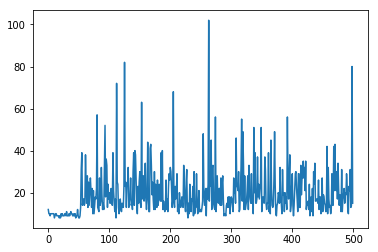

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(training_history)

In [9]:
display_frames_as_gif(frames)

IndexError: list index out of range